In [1]:
import os
import json  # change the data info from dictionary to json file
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit  # fit the data with a given form

In [2]:
# import the packages for symbolic regression
import sympy
import pydotplus
from IPython.display import Image
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sympy.plotting import plot as symplot

In [1]:
from utils import extractFolderList  # Getting folder list
from utils import extractFileInfo  # Getting all path

# Getting the data structure

In [3]:
# Getting the absolute path of our file
ab_path_now = os.path.abspath('.')
print(ab_path_now)

E:\PythonTest\AiFeynmanTest


In [4]:
def extractFolderList(ab_path_now, data_folder):
    """
    Load the folder's path with various kinds of data 
    """
    folder_path_list = [] 
    name_list = []

    data_path = os.path.join(ab_path_now, data_folder)
    path_dir = os.listdir(data_path)
    for child_dir in path_dir:
        child_path = os.path.join(data_path, child_dir)
        if os.path.isdir(child_path):
            # Obtain the folder path 
            folder_path_list.append(child_path)

            # Extract the folder name
            name, _ = child_dir.split('_')
            name_list.append(name)
        elif os.path.isfile(child_path):
            print(child_path, 'is a file')
        else:
            print('It is a sepcial file')
    
    return folder_path_list, name_list


data_folder = 'SK_Data'
folder_path_list, folder_name_list = extractFolderList(ab_path_now, data_folder)

E:\PythonTest\AiFeynmanTest\SK_Data\.DS_Store is a file


In [5]:
folder_name_list

['diffusiveWall', 'Maxwellian', 'specifiedV']

In [6]:
def extractFileInfo(folder_path):
    """
    Create a dictionary containing all the data, the key is the name of file, 
    the value is the path of the file. 
    """
    
    file_name_list = []
    file_list = []
    data_info = {}

    path_dir = os.listdir(folder_path)
    for child_dir in path_dir:
        name, _ = child_dir.split('.')
        if name and (name != 'REDEME'):
            file_name_list.append(name)
            file_path = os.path.join(folder_path, child_dir)
            file_list.append(file_path)
            data_info[name] = file_path

    return file_name_list, file_list, data_info


data_dic = {}
for folder_path, folder_name in zip(folder_path_list, folder_name_list):
    _, _, data_info = extractFileInfo(folder_path)
    data_dic[folder_name] = data_info

In [7]:
# store all information of our data into a json file
json_str = json.dumps(data_dic, indent=4)
with open('data_info.json', 'w') as json_file:
    json_file.write(json_str)


In [8]:
# Extract the data in diffusiveWall 
meas_velocity_path = data_dic['diffusiveWall']['3_meas_velocities_top']
vname_list = ['vxStart', 'vyStart', 'vzStart', 'vxEnd', 'vyEnd', 'vzEnd' ]
velocity_data = pd.read_csv(meas_velocity_path, names=vname_list, 
                            header=None, sep=" ")

In [9]:
velocity_data.head(5)

,vxStart,vyStart,vzStart,vxEnd,vyEnd,vzEnd
0,50,10,10,308.450,516.9850,-334.376
1,50,10,10,-483.209,-42.9309,-529.664
2,50,10,10,461.235,-617.8650,-355.006
3,50,10,10,-108.283,924.4150,-1029.280
4,50,10,10,-381.932,131.0570,-623.617


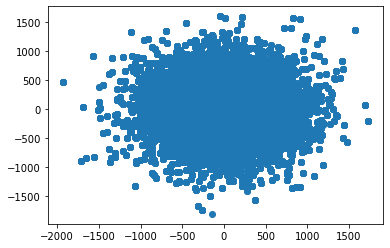

In [10]:
# scattering plot for the end
plt.scatter(velocity_data['vxEnd'], velocity_data['vyEnd'])


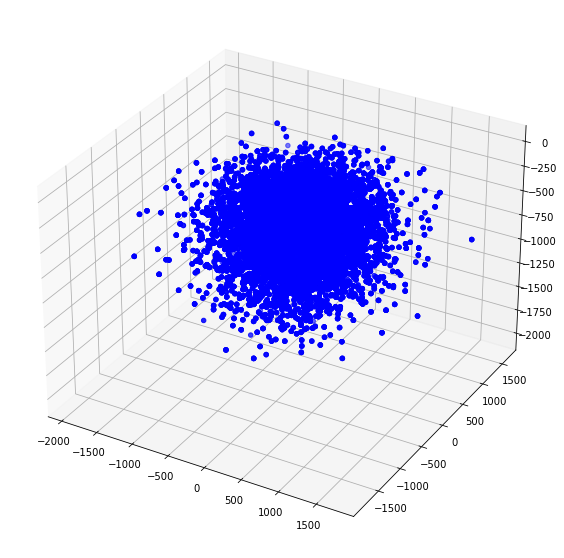

In [11]:
fig = plt.figure(figsize=(12, 10))
font_format = {'family': 'Times New Roman', 'size': 16}

ax = fig.add_subplot(1, 1, 1, projection='3d')
start_point = ax.scatter(velocity_data['vxStart'], velocity_data['vyStart'], 
                         velocity_data['vzStart'], c='r')
end_point = ax.scatter(velocity_data['vxEnd'], velocity_data['vyEnd'], 
                       velocity_data['vzEnd'], c='b')

In [12]:
# reflected velocity distribution for tangential component
tan_velocity_x_path = data_dic['diffusiveWall']['velocity_histogram_tangential_x']
tan_vel_name_x_list = ['vt_x', 'number', 'prob_vtx']
tan_vel_x = pd.read_csv(tan_velocity_x_path, names=tan_vel_name_x_list, 
                        header=None, sep=" ")
tan_vel_x.head(5)

,vt_x,number,prob_vtx
0,-1995,0,0.0
1,-1985,0,0.0
2,-1975,0,0.0
3,-1965,0,0.0
4,-1955,0,0.0


# Visualize the data

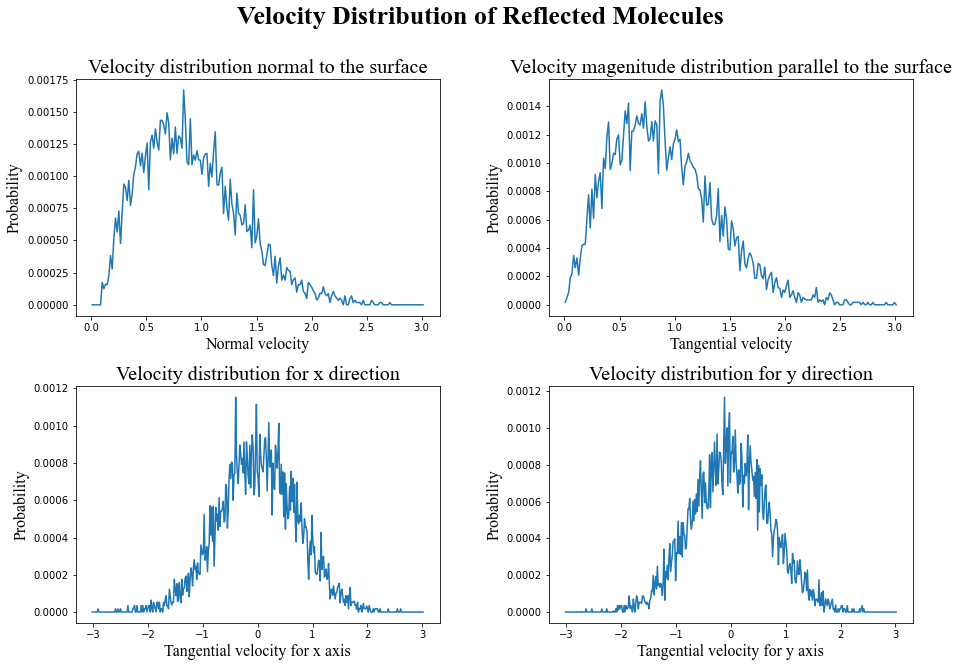

In [13]:
def extracData(folder_name, file_name):
    data_path = data_dic[folder_name][file_name]
    data = pd.read_csv(data_path, header=None, sep=" ")

    v = data.iloc[:, 0]
    number = data.iloc[:, 1]
    prob = data.iloc[:, 2]

    return v, number, prob


def calVm():
    kB = 1.38064852e-23  # Boltzman const
    Tw = 423  # Temperature of the wall
    mi = 2.66389e-26  # Molecular mass of methane

    Vm = np.sqrt(2 * kB * Tw / mi)  # Most probable speed
    Vm0 = np.sqrt(kB * Tw / mi)  # reference velocity factor

    return Vm, Vm0


Vm, _ = calVm()

folder_name = 'diffusiveWall'
file_list = [
    'velocity_histogram_normal', 'velocity_histogram_tangential',
    'velocity_histogram_tangential_x', 'velocity_histogram_tangential_y'
]
velocity_list = [
    'Normal velocity', 'Tangential velocity', 'Tangential velocity for x axis',
    'Tangential velocity for y axis'
]
title_list = [
    'Velocity distribution normal to the surface',
    'Velocity magenitude distribution parallel to the surface',
    'Velocity distribution for x direction',
    'Velocity distribution for y direction'
]
font_format = {'family': 'Times New Roman', 'size': 16}
title_format = {'family': 'Times New Roman', 'size': 20}
suptitle_format = {'family': 'Times New Roman'}

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Velocity Distribution of Reflected Molecules',
             fontdict=suptitle_format,
             fontsize=26,
             fontweight='bold')
for i, file in enumerate(file_list):
    v, _, prob = extracData(folder_name, file)
    ax = fig.add_subplot(2, 2, i + 1)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax.plot(v/Vm, prob)
    ax.set_xlabel(velocity_list[i], fontdict=font_format)
    ax.set_ylabel('Probability', fontdict=font_format)
    ax.set_title(title_list[i], fontdict=title_format)

plt.savefig('./figure/velocity dirstribution.png')

# Fit the tangential velocity using Scipy

Fited parameters: A is 67.16646737721325, B is 35.54591839207668


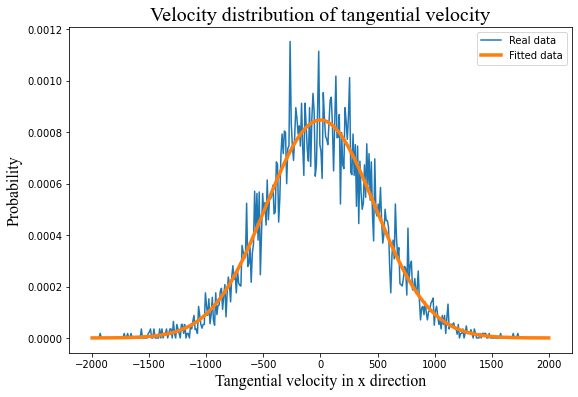

In [14]:
def fitFunction(x, A, B):
    y = np.power(1 / (np.pi * B), 3 / 2) * np.exp(-(x / 10)**2 / np.square(A))

    return y


xdata, _, ydata = extracData(folder_name, file_list[2])
guess = [25, 50]
parameters, covariance = curve_fit(fitFunction, xdata, ydata, p0=guess)
print('Fited parameters: A is {}, B is {}'.format(parameters[0],
                                                  parameters[1]))
fit_y = fitFunction(xdata, parameters[0], parameters[1])
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata, ydata, label='Real data')
plt.plot(xdata, fit_y, label='Fitted data', linewidth=3.5)
plt.xlabel('Tangential velocity in x direction', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of tangential velocity',
          fontdict=title_format)
plt.legend()

plt.savefig('./figure/vt_x and fitted data.png')

The fitted distributio equation is 
$$ f = \left(\frac{1}{35.546\pi}\right)^{\frac{3}{2}} \mathrm{exp}\left(-\frac{v^2}{670^2}\right)$$


## FIt travial for normal velocity
From the plot, we could see that the fitted data fits the data very well compared to the theoretical plot. Here, we use the following formula to fit the data, i.e., the diffuse scattering kernel of normal velocity,
$$f = \frac{mV_{n}}{k_BT_w}\times\mathrm{exp}\left(-\frac{V_{n}^2}{v_m^2}\right) $$

The size of data is (200,)
Theoretically, the value of B is 4.561343601877912e-06, and the value of A is 662.1686318778972
Fited parameters: A is 676.4220413601845, B is 4.489586353153203e-06


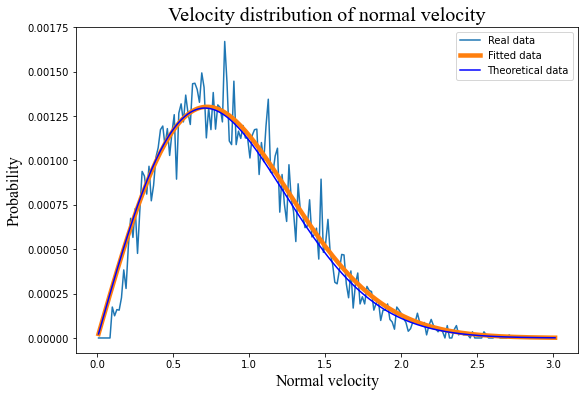

In [15]:
# kB = 1.38064852e-23  # Boltzman const
# Tw = 423  # Temperature of the wall
# mi = 2.66389e-26  # Molecular mass of methane
gas_properties = {'kB': 1.38064852e-23, 'Tw': 423, 'mi': 2.66389e-26}


def fitFunctionNormal(x, A, B):
    """
    x: Normal velocity of Maxwellian distribution
    A: Fitted paprameter
    B: Fitted paprameter
    """
    y = (B * x) * np.exp(-(x)**2 / np.square(A))

    return y


def theoDataNormal(Cm, x, parameters):
    """
    Parameters is a dictionary that contains the properties of gas.
    Cm: The most probable speed
    x: The normal velocity of Maxwellian distribution
    kB: Boltzman const
    Tw: Temperature of the wall
    mi: Molecular mass fof methane
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    B = mi / (kB * Tw)
    A = 2 * kB * Tw / mi
    x = np.array(x)
    f = B * x * np.exp(-np.square(x) / A)
    print("The size of data is {}".format(f.shape))
    print(
        'Theoretically, the value of B is {}, and the value of A is {}'.format(
            B, np.sqrt(A)))

    return f


xdata_normal, _, ydata_normal = extracData(folder_name, file_list[0])
f_normal = theoDataNormal(Vm, xdata_normal,
                          gas_properties)  # calculate the theoretical value
guess_normal = [650, 4e-6]
parameters_normal, _ = curve_fit(fitFunctionNormal,
                                 xdata_normal,
                                 ydata_normal,
                                 p0=guess_normal) 
print('Fited parameters: A is {}, B is {}'.format(parameters_normal[0],
                                                  parameters_normal[1]))
fit_y_normal = fitFunctionNormal(xdata_normal, parameters_normal[0],
                                 parameters_normal[1])
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata_normal / Vm, ydata_normal, label='Real data')
plt.plot(xdata_normal / Vm, fit_y_normal, label='Fitted data', linewidth=4.5)
plt.plot(xdata_normal / Vm, f_normal, label='Theoretical data', linewidth=1.5,
         c='b')
plt.xlabel('Normal velocity', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of normal velocity', fontdict=title_format)
plt.legend()

plt.savefig('./figure/vn and fitted data.png')

## Normalizad fit travial for tangential velocity

During analysis, I found a very interesting problem, even though we have talked some in last meeting, I still want to pi=ut it here. From the theoretical data, we know that the mathematical expression is 
$$f = \frac{1}{\sqrt{\pi}v_m}\times\mathrm{exp}\left(-\frac{V_{t, x}^2}{v_m^2}\right)
\label{eq: tangential velocity probability}
$$

Apparently, Equation \ref{eq: tangential velocity probability} is different from the expression given by Yichong, i.e., 
$$ f = \left(\frac{1}{v_m^2\pi}\right)^{\frac{3}{2}} \mathrm{exp}\left(-\frac{V^2}{v_m^2}\right)
\label{eq: diffuse kernel by Yichong}
$$

So, the quertion is that the $V$ in Equation \ref{eq: diffuse kernel by Yichong} could not be simply replaced by $V_{t, x}$, right? 


The size of data is (400,)
Fited parameters: A is 671.6643897840231, B is 665.7855884197883


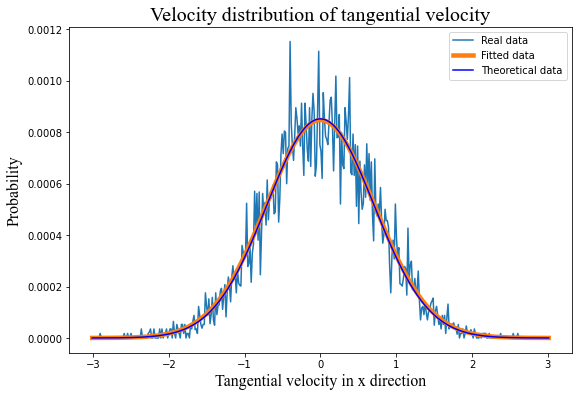

In [16]:
def fitFunction(x, A, B):
    y = (1 / (np.sqrt(np.pi) * B)) * np.exp(-(x)**2 / np.square(A))

    return y


def theoData(Cm, x):
    x = np.array(x)
    f = 1 / (np.sqrt(np.pi) * Cm) * np.exp(-np.power(x, 2) / Cm**2)
    print("The size of data is {}".format(f.shape))

    return f


xdata, _, ydata = extracData(folder_name, file_list[2])
f = theoData(Vm, xdata)
guess = [25, 50]
parameters, covariance = curve_fit(fitFunction, xdata, ydata, p0=guess)
print('Fited parameters: A is {}, B is {}'.format(parameters[0],
                                                  parameters[1]))
fit_y = fitFunction(xdata, parameters[0], parameters[1])
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata / Vm, ydata, label='Real data')
plt.plot(xdata / Vm, fit_y, label='Fitted data', linewidth=4.5)
plt.plot(xdata / Vm, f, label='Theoretical data', linewidth=1.5, c='b')
plt.xlabel('Tangential velocity in x direction', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of tangential velocity',
          fontdict=title_format)
plt.legend()

plt.savefig('./figure/vt_x and fitted data.png')

# Obtaining the symbolic expression via gplearn
## Prepare the data
For this example, we are still doing the data research into velocity distribution of tangent component along x axis

In [17]:
X = copy.deepcopy(xdata)
y = copy.deepcopy(ydata)


def splitDataset(X, y, ratio):
    dataset = np.array([X.values, y.values]).transpose()
    print(dataset.shape)
    np.random.shuffle(dataset)
    index = int(len(X)*ratio)
    print(dataset[0])
    X_train = dataset[:index, :][:, 0]
    y_train = dataset[:index, :][:, 1]
    X_test = dataset[index:, :][:, 0]
    y_test = dataset[index:, :][:, 1]
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = splitDataset(X, y, 0.8)

(400, 2)
[-8.95000e+02  1.25828e-04]


In [18]:
fit_y.shape

(400,)

## Symbolic regression

In [20]:
# self-made function
def exponential(x):
    a = np.exp(x)
    a[~np.isfinite(a)] = 0

    return a


def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    _EPS = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_x2 = np.abs(x2, dtype=np.float64)
        return np.where(
            np.abs(x2) > _EPS, np.divide(x1, x2),
            np.sign(x2) * np.divide(x1, abs_x2 + _EPS))


def _protected_log(x1):
    """Closure of log for zero arguments."""
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_x1 = np.abs(x1, dtype=np.float64)
        return np.where(abs_x1 > _EPS, np.log(abs_x1), np.log(abs_x1 + _EPS))


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    Cm = 650
    compare_value = 65
    with np.errstate(divide='ignore', invalid='ignore'):
#         if x < compare_value:
#             exp_f = 1. + x**2/Cm**2
#         else:
        exp_f = np.exp(x**2 / Cm**2)
        return np.where(exp_f > 8.9e6, 0, exp_f)
 
    
def _protectedSquare(x1):
    """
    Clourse of square for large input data
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        square_f = np.square(x1)
        # return np.where(square_f > 6e6, 1, square_f)
        return square_f
    
    
# expo_fun = make_function(function=exponential, name='exp', arity=1)
expo_fun = make_function(function=_protectedExp, name='exp', arity=1)
self_div = make_function(function=_protected_division, name='div', arity=2)
self_square = make_function(function=_protectedSquare, name='square', arity=1)
# const_fun = make_function(function=_protectedConstant, name='const', arity=0)
fun_set = ['add', 'sub', 'mul', 'neg', 'div', expo_fun, self_square]
const_limit = 2e-3

est_gp = SymbolicRegressor(population_size=600,
                           function_set=fun_set,
                           generations=600,
                           stopping_criteria=0.00021,
                           const_range=(-const_limit, const_limit),
                           p_crossover=0.6,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05,
                           p_point_mutation=0.1,
                           max_samples=0.9,
                           verbose=1,
                           parsimony_coefficient=0.01,
                           random_state=0,
                           n_jobs=2,
                           low_memory=True)
# X_train_1 = X_train[:, np.newaxis]
# y_train_1 = y_train
X_train_1 = xdata[:, np.newaxis]
y_train_1 = fit_y
est_gp.fit(X_train_1, y_train_1)

<ipython-input-20-c7ba1e4a41bc>:75: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train_1 = xdata[:, np.newaxis]


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.77       2.3013e+43       26      0.000239418      0.000367253     15.65m
   1     7.56      5.25856e+35        4      0.000235031      0.000234089      2.77m
   2     2.32      1.29864e+12        3      0.000232368      0.000270192      2.57m
   3     1.44      3.73316e+15        1      0.000230375      0.000288136      2.68m
   4     1.37      1.51272e+16        1       0.00022677      0.000320577      2.47m
   5     1.36          8783.05        1       0.00022558      0.000331284      2.49m
   6     1.32      1.01512e+09        1        0.0002254      0.000332904      2.51m
   7     1.41      1.98157e+15        1      0.000224876      0.000337622      2.50m
   8     1.43      1.71789e+06        1      0.000225895      0.000328453  

SymbolicRegressor(const_range=(-0.002, 0.002),
                  function_set=['add', 'sub', 'mul', 'neg', 'div',
                  generations=600, low_memory=True, max_samples=0.9, n_jobs=2,
                  p_crossover=0.6, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=600, random_state=0,
                  stopping_criteria=0.00021, verbose=1)

In [25]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x / y,
    'mul': lambda x, y : x * y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : - x,
    'pow': lambda x, y : x ** y,
    'sin': lambda x    : sympy.sin(x),
    'cos': lambda x    : sympy.cos(x),
    'inv': lambda x    : 1 / x,
    'sqrt': lambda x   : x ** 0.5,
    'exp': lambda x    : sympy.exp(x**2),
    'square': lambda x : x ** 2
}

print(est_gp)
# print('R2:', est_gp.score(X_test[:, np.newaxis], y_test))
next_e = sympy.sympify((est_gp._program), locals=converter)
print('Expression:', next_e)

div(add(0.002, -0.001), exp(X0))
Expression: 0.001*exp(-X0**2)


D:\SoftwareAPPs\Anaconda\AnacondaInstaller\lib\site-packages\sympy\core\sympify.py:383: SymPyDeprecationWarning: 

String fallback in sympify has been deprecated since SymPy 1.6. Use
sympify(str(obj)) or sympy.core.sympify.converter or obj._sympy_
instead. See https://github.com/sympy/sympy/issues/18066 for more
info.

  SymPyDeprecationWarning(


From the Expression given by sympy, we notice that there is no other term in exponential function but x instead, this is beacuse we have use $v_m$ scaling the velocity.

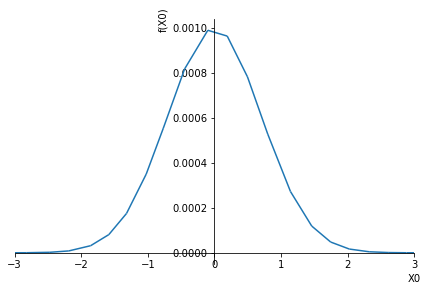

In [26]:
symplot(next_e, xlim=[-3, 3])

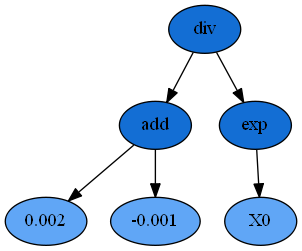

In [27]:
graph = est_gp._program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())